# Statement of the problem

The aim of this work is to develop an autoencoder model capable of restoring original images distorted by a watermark. To do this, it is necessary to:
* Use a dataset of images without watermarks;
* Create a mechanism for generating artificial watermarks;
* Train the autoencoder on the task of removing the watermark;
* Visualize the results of restoration;
* Apply augmentations to improve the stability of the model;
* Conduct step-by-step training with control over the use of RAM;
* Evaluate the quality of the model on a control sample.

## 1. Uploading images without watermarks

### Loading required libraries

In [1]:
# Array operations
import numpy as np

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Model constructor
from keras.models import Model

# Utilities
from keras import utils

# Layers
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, UpSampling2D, Conv2DTranspose, BatchNormalization

# Optimizer
from keras.optimizers import Adam

# Callbacks
from keras.callbacks import EarlyStopping

# OpenCV for image processing
import cv2

# File and path operations
import os

# Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Train/test split
from sklearn.model_selection import train_test_split

# Random selection
import random

### Loading dataset

In [2]:
!wget https://storage.yandexcloud.net/academy.ai/watermarked.zip

--2025-06-11 07:11:04--  https://storage.yandexcloud.net/academy.ai/watermarked.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 731796045 (698M) [application/x-zip-compressed]
Saving to: ‘watermarked.zip’

watermarked.zip     100%[===================>] 697.89M  14.1MB/s    in 56s     

2025-06-11 07:12:01 (12.4 MB/s) - ‘watermarked.zip’ saved [731796045/731796045]



In [3]:
!unzip -qo "watermarked.zip" -d ./watermarked

### Let's form paths to files

In [4]:
train_path = './watermarked/wm-nowm/train/no-watermark'   # training dataset
valid_path = './watermarked/wm-nowm/valid/no-watermark'   # validation dataset

# Check contents
print("Training images:", len(os.listdir(train_path)))
print("Validation images:", len(os.listdir(valid_path)))

Training images: 12477
Validation images: 3289


## Saving paths to images

In [5]:
train_nonwatermarked = sorted([os.path.join(train_path, fname) for fname in os.listdir(train_path)])
valid_nonwatermarked = sorted([os.path.join(valid_path, fname) for fname in os.listdir(valid_path)])

print("Done! Loaded:")
print(f"{len(train_nonwatermarked)} training images without watermarks")
print(f"{len(valid_nonwatermarked)} control images without watermarks")

Done! Loaded:
12477 training images without watermarks
3289 control images without watermarks


#2. Applying watermarks to images

## Importing required libraries

In [6]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

## Function for applying a watermark

In [7]:
def apply_watermark_on_image(image, text: str = "WATERMARK", opacity: float = 0.9):
    overlay = image.copy()
    output = image.copy()

    font = cv2.FONT_HERSHEY_SIMPLEX
    scale = 0.5
    thickness = 1
    color = (255, 255, 255)

    text_size, _ = cv2.getTextSize(text, font, scale, thickness)
    text_width, text_height = text_size

    x = (image.shape[1] - text_width) // 2
    y = image.shape[0] - 10

    cv2.putText(overlay, text, (x, y), font, scale, color, thickness, cv2.LINE_AA)
    cv2.addWeighted(overlay, opacity, output, 1 - opacity, 0, output)

    return output

# 3. Autoencoder structure

## Autoencoder Goal

* Input: watermarked image
* Output: unwatermarked image
* Task: autoencoder should learn to "restore" original image

## General structure of autoencoder
1. Encoder: compresses image by extracting features
2. Decoder: restores image without unnecessary information

In [8]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation

def build_autoencoder(input_shape=(128, 128, 3)):
    input_img = Input(shape=input_shape)

    # --- Encoder ---
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # --- Decoder ---
    x = Conv2D(128, (3, 3), padding='same')(encoded)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)

    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Model
    autoencoder = Model(inputs=input_img, outputs=decoded)
    return autoencoder

# 4. Resize and apply watermark

In [9]:
import numpy as np
import cv2
from tqdm import tqdm

# Image size
IMG_SIZE = 128
LIMIT = 1000

# Preprocessing function
def preprocess_images_with_watermark(image_paths, limit=None):
    X = []
    Y = []
    for path in tqdm(image_paths[:limit]):
        img = cv2.imread(path)
        if img is None:
            continue

        # Resize to target size
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        # Clean image (Y)
        clean = img_resized.astype('float32') / 255.0
        Y.append(clean)

        # Image with watermark (X)
        with_watermark = apply_watermark_on_image(img_resized)
        with_watermark = with_watermark.astype('float32') / 255.0
        X.append(with_watermark)

    return np.array(X), np.array(Y)

## Apply to training and validation samples

In [10]:
X_train, Y_train = preprocess_images_with_watermark(train_nonwatermarked, limit=LIMIT)
X_valid, Y_valid = preprocess_images_with_watermark(valid_nonwatermarked, limit=200)

print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")
print(f"X_valid: {X_valid.shape}")
print(f"Y_valid: {Y_valid.shape}")

100%|██████████| 200/200 [00:00<00:00, 442.01it/s]

X_train: (1000, 128, 128, 3)
Y_train: (1000, 128, 128, 3)
X_valid: (200, 128, 128, 3)
Y_valid: (200, 128, 128, 3)


## Output of array forms

In [11]:
print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")
print(f"X_valid: {X_valid.shape}")
print(f"Y_valid: {Y_valid.shape}")

X_train: (1000, 128, 128, 3)
Y_train: (1000, 128, 128, 3)
X_valid: (200, 128, 128, 3)
Y_valid: (200, 128, 128, 3)


# 5. Compilation and training of the model

## Assembling and compiling the model

In [12]:
# Building the autoencoder
autoencoder = build_autoencoder(input_shape=(128, 128, 3))

# Compilation
autoencoder.compile(
    optimizer='adam',
    loss='mse'
)

# Model architecture summary
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 335,747 (1.28 MB)

 Trainable params: 334,851 (1.28 MB)

 Non-trainable params: 896 (3.50 KB)

## Model training

In [13]:
from keras.callbacks import EarlyStopping

# Stop training if no improvement in validation loss
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Training
history = autoencoder.fit(
    X_train, Y_train,
    epochs=30,
    batch_size=32,
    shuffle=True,
    validation_data=(X_valid, Y_valid),
    callbacks=[early_stop]
)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 240ms/step - loss: 0.0396 - val_loss: 0.0906
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0142 - val_loss: 0.0790
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0126 - val_loss: 0.0672
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0117 - val_loss: 0.0540
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0108 - val_loss: 0.0451
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0105 - val_loss: 0.0326
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0098 - val_loss: 0.0289
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0104 - val_loss: 0.0238
Epoch 9/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0102 - val_loss: 0.0185
Epoch 10/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0093 - val_loss: 0.0174
Epoch 11/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0099 - val_loss: 0.0121
Epoch 12/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0

## Predictions on the control sample

In [14]:
preds = autoencoder.predict(X_valid)
print(f"Prediction shape: {preds.shape}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step
Prediction shape: (200, 128, 128, 3)


## Training schedule

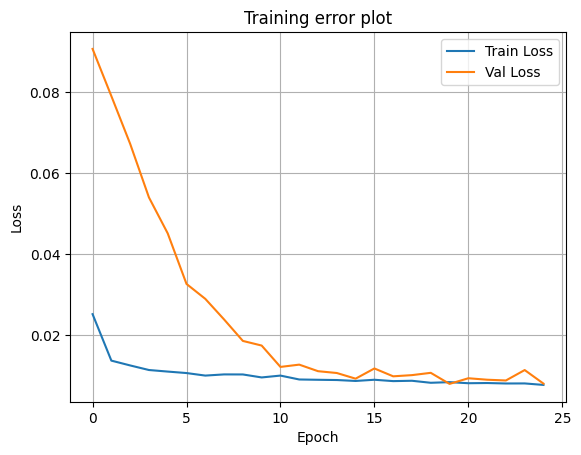

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training error plot")
plt.grid()
plt.show()

# 6. Demonstration of examples

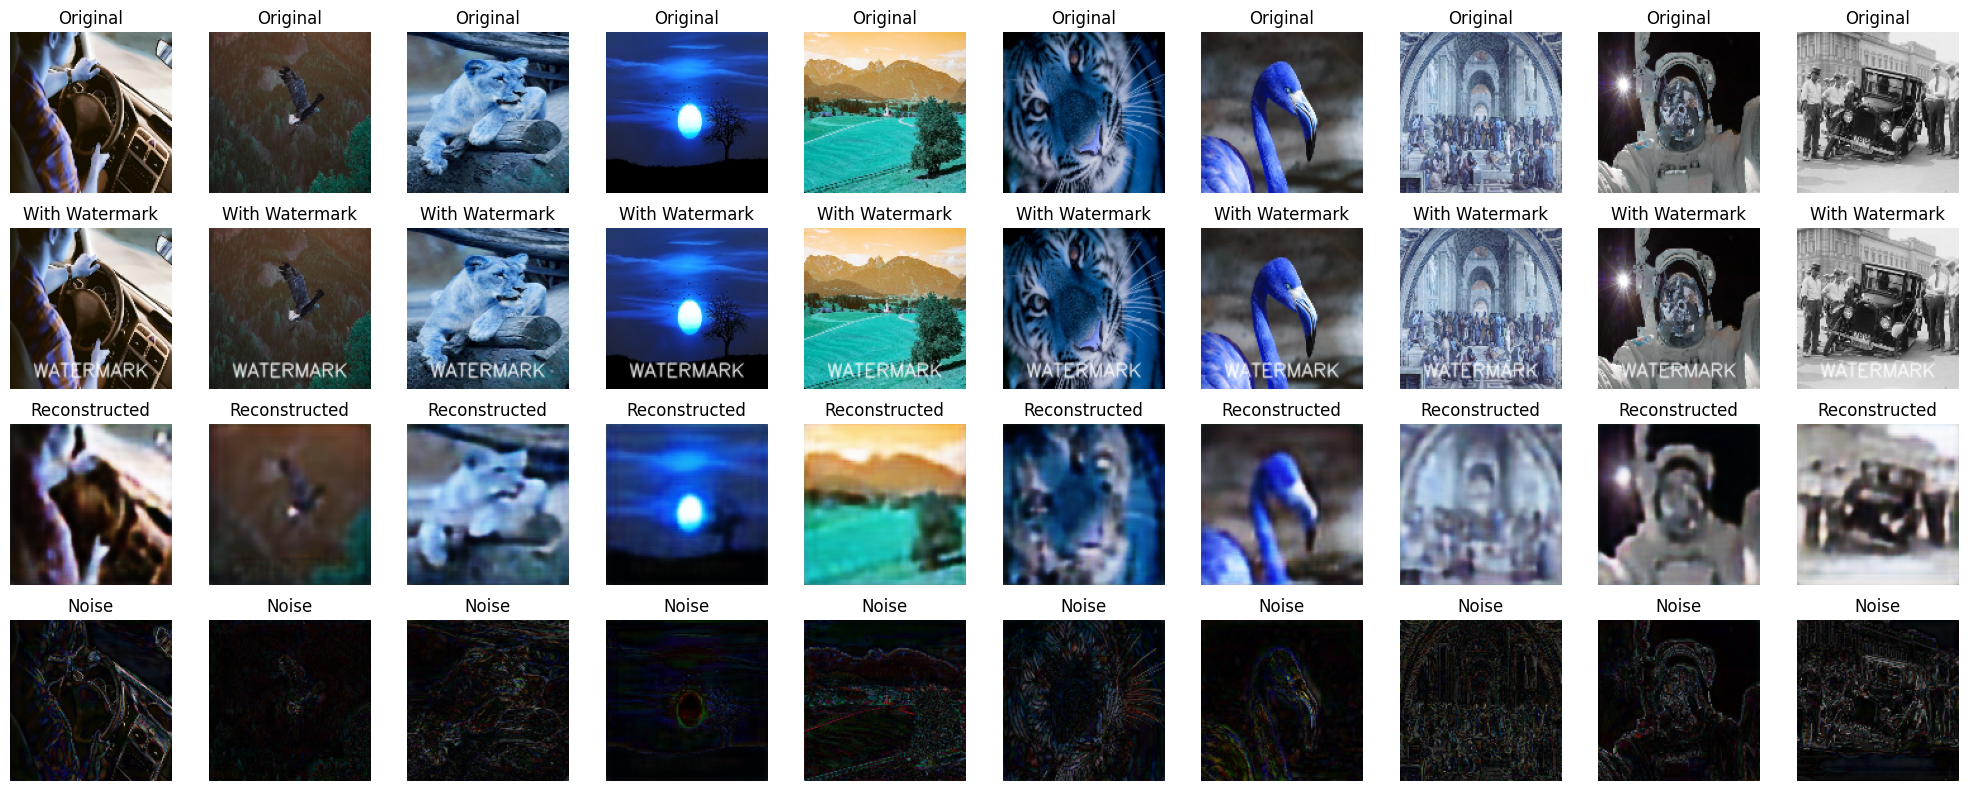

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure predictions are within valid range
preds = np.clip(preds, 0.0, 1.0)

def show_denoising_results(X, Y_true, Y_pred, n=10):
    plt.figure(figsize=(20, 8))

    for i in range(n):
        # 1. Original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(Y_true[i])
        ax.set_title("Original")
        plt.axis("off")

        # 2. With watermark
        ax = plt.subplot(4, n, i + 1 + n)
        plt.imshow(X[i])
        ax.set_title("With Watermark")
        plt.axis("off")

        # 3. Reconstructed
        ax = plt.subplot(4, n, i + 1 + 2 * n)
        plt.imshow(Y_pred[i])
        ax.set_title("Reconstructed")
        plt.axis("off")

        # 4. Noise
        noise = np.abs(Y_pred[i] - Y_true[i])
        ax = plt.subplot(4, n, i + 1 + 3 * n)
        plt.imshow(noise)
        ax.set_title("Noise")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_denoising_results(X_valid, Y_valid, preds, n=10)

# 7. Image augmentation (5+ types)

In [17]:
import os
import cv2
import random
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

## Augmentation functions

In [18]:
def augment_image(image):
    img = tf.convert_to_tensor(image / 255.0, dtype=tf.float32)

    img = tf.image.random_brightness(img, max_delta=0.2)                    # 1. Brightness
    img = tf.image.random_contrast(img, lower=0.5, upper=1.5)               # 2. Contrast
    img = tf.image.random_flip_left_right(img)                              # 3. Horizontal flip
    img = tf.image.random_saturation(img, lower=0.7, upper=1.3)             # 4. Saturation
    img = tf.image.random_hue(img, max_delta=0.05)                          # 5. Hue

    img = tf.clip_by_value(img, 0.0, 1.0)
    img = tf.image.resize(img, [128, 128])
    img = (img.numpy() * 255).astype(np.uint8)

    return img

## Generation of augmented data

In [20]:
X_augmented = []
Y_augmented = []

LIMIT = 1000

for path in tqdm(train_nonwatermarked[:LIMIT]):
    img = cv2.imread(path)
    if img is None:
        continue

    img_resized = cv2.resize(img, (128, 128))
    y = img_resized.astype('float32') / 255.0  # Clean target image

    x_aug = augment_image(img_resized)         # Augmented image
    x_aug = apply_watermark_on_image(x_aug)    # Apply watermark on top
    x = x_aug.astype('float32') / 255.0        # Normalize

    X_augmented.append(x)
    Y_augmented.append(y)

100%|██████████| 1000/1000 [00:08<00:00, 124.16it/s]


## Convert to NumPy

In [21]:
X_augmented = np.array(X_augmented)
Y_augmented = np.array(Y_augmented)

print(f"X_augmented: {X_augmented.shape}")
print(f"Y_augmented: {Y_augmented.shape}")

X_augmented: (1000, 128, 128, 3)
Y_augmented: (1000, 128, 128, 3)


## Сheck

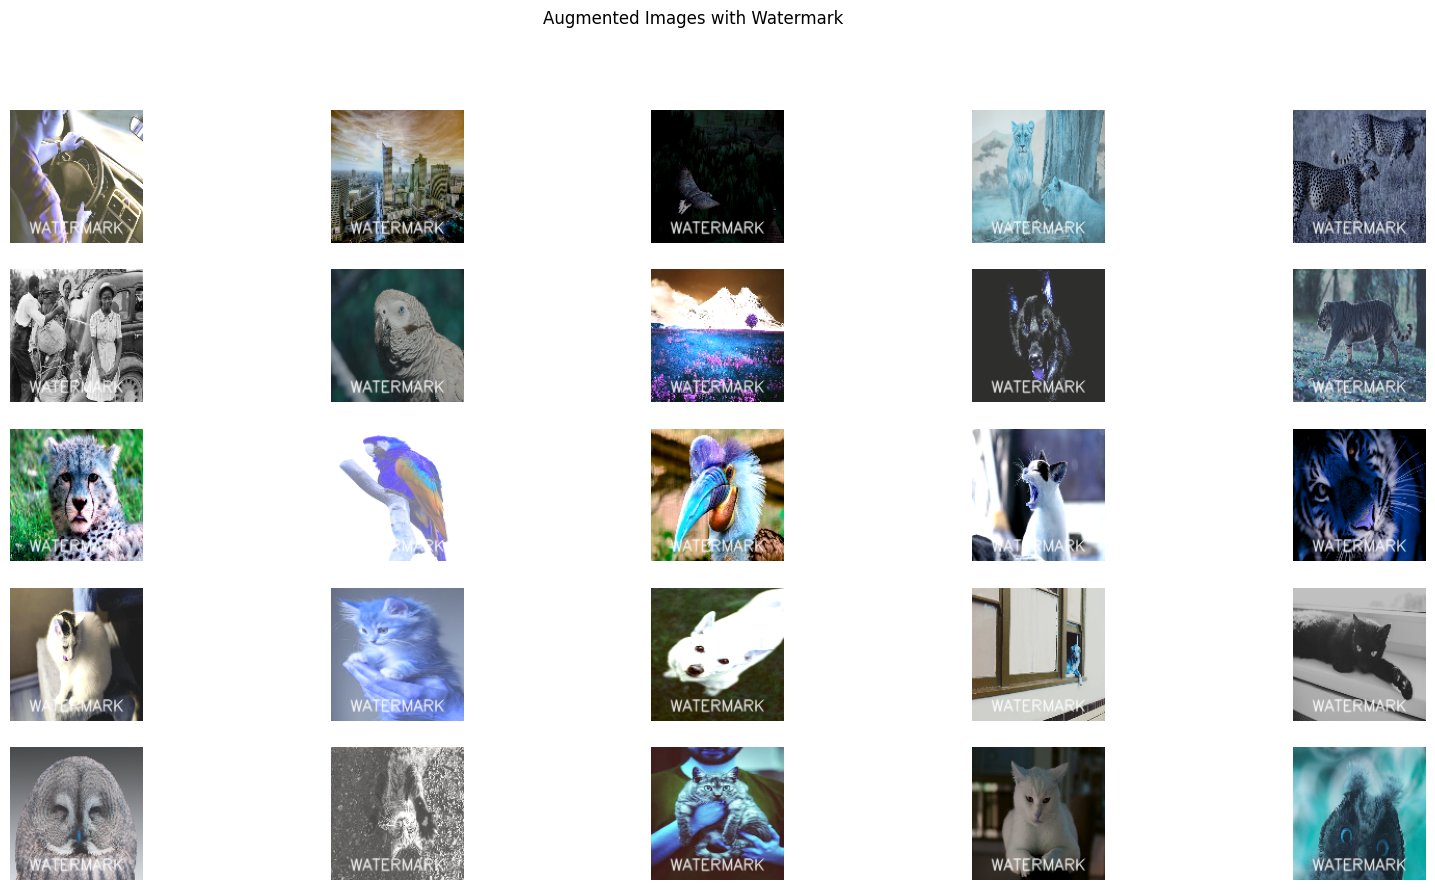

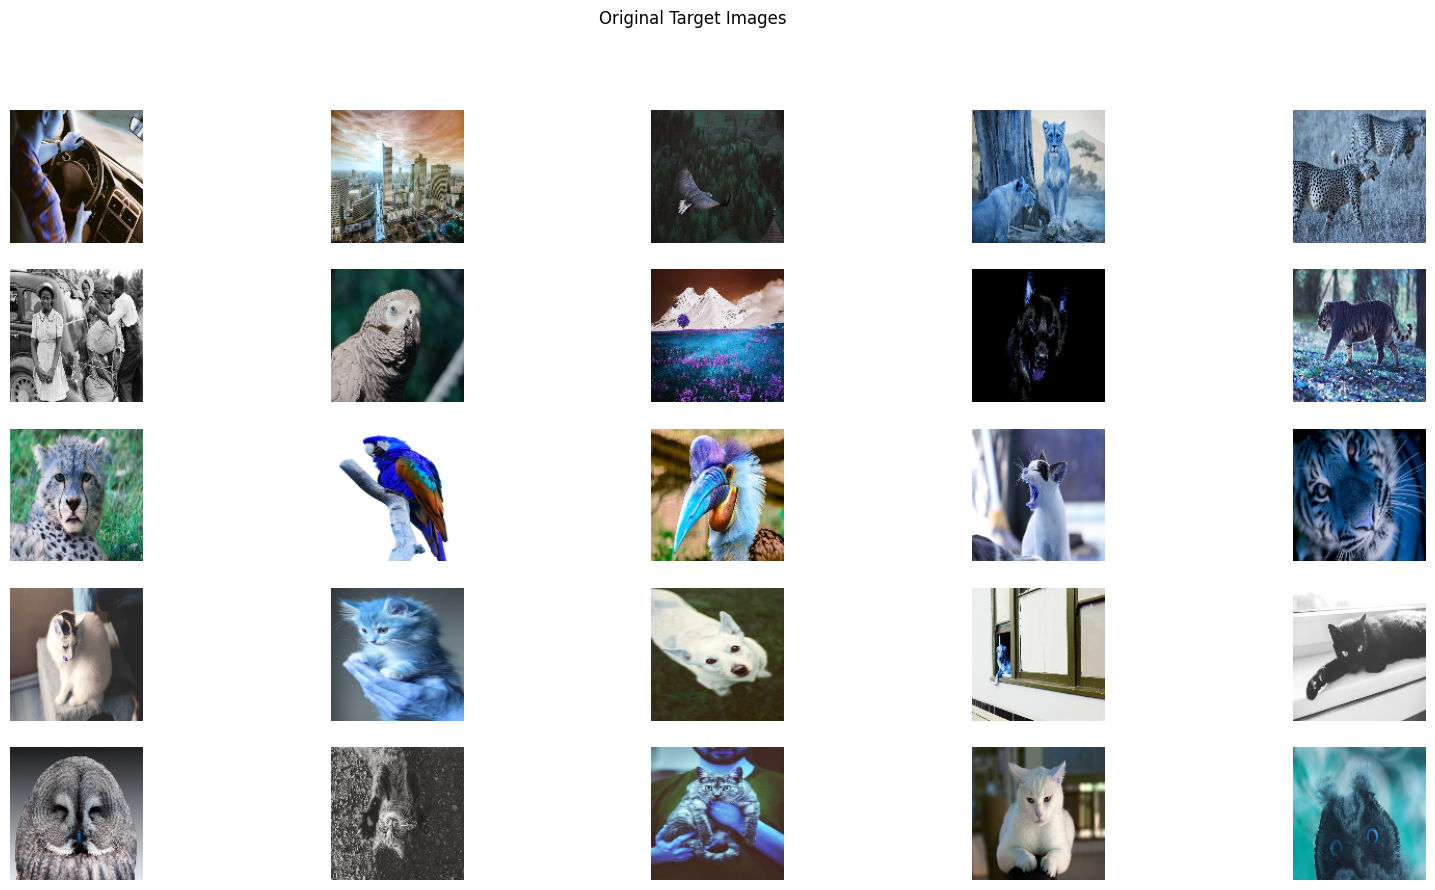

In [22]:
plt.figure(figsize=(20, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_augmented[i])
    plt.axis('off')
plt.suptitle("Augmented Images with Watermark")
plt.show()

plt.figure(figsize=(20, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(Y_augmented[i])
    plt.axis('off')
plt.suptitle("Original Target Images")
plt.show()

## Merging samples and normalization

In [23]:
X_train_full = np.concatenate([X_train, X_augmented], axis=0)
Y_train_full = np.concatenate([Y_train, Y_augmented], axis=0)

## Normalization of all data

In [24]:
X_train_full = X_train_full.astype('float32') / 255.0 if X_train_full.max() > 1 else X_train_full
Y_train_full = Y_train_full.astype('float32') / 255.0 if Y_train_full.max() > 1 else Y_train_full
X_valid = X_valid.astype('float32') / 255.0 if X_valid.max() > 1 else X_valid
Y_valid = Y_valid.astype('float32') / 255.0 if Y_valid.max() > 1 else Y_valid

## Let's check

In [25]:
print(f"X_train_full shape: {X_train_full.shape}")
print(f"Y_train_full shape: {Y_train_full.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"Y_valid shape: {Y_valid.shape}")

X_train_full shape: (2000, 128, 128, 3)
Y_train_full shape: (2000, 128, 128, 3)
X_valid shape: (200, 128, 128, 3)
Y_valid shape: (200, 128, 128, 3)


# 8. Training a model with augmented data

Train the model in 3 or more stages, loading a subset of the training data each time, rather than the entire dataset at once.

## Strategy:

1. Split `X_train_full` and `Y_train_full` into N parts (e.g. 3)
2. At each step:
* Train the model on this part
* Adjust parameters if necessary (batch size, lr, etc.)
* Free memory (`gc.collect()`, `del`, `tf.keras.backend.clear_session()` are not required between epochs, but can be used between cycles)
3. Use EarlyStopping or save the intermediate model

## Import and preparation

In [26]:
import gc
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Block size
n_steps = 3
epochs_per_step = 10

# Callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#Model
autoencoder = build_autoencoder(input_shape=(128, 128, 3))
optimizer = Adam(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer, loss='mse')

## Single serving loading and preparation function

In [27]:
def load_augmented_batch(image_paths):
    X_batch = []
    Y_batch = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is None:
            continue
        img_resized = cv2.resize(img, (128, 128))
        y = img_resized.astype('float32') / 255.0

        x_aug = augment_image(img_resized)  # with augmentation
        x_aug = apply_watermark_on_image(x_aug)
        x = x_aug.astype('float32') / 255.0

        X_batch.append(x)
        Y_batch.append(y)
    return np.array(X_batch), np.array(Y_batch)

## Iterative learning

In [28]:
step_size = len(X_train_full) // n_steps

for step in range(n_steps):
    print(f"\n=== 🔁 Step {step + 1}/{n_steps} ===")

    # Load a portion of X_train_full
    start = step * step_size
    end = (step + 1) * step_size

    X_batch = X_train_full[start:end]
    Y_batch = Y_train_full[start:end]

    # Adjust training parameters
    if step == 1:
        autoencoder.optimizer.learning_rate.assign(0.0005)
        print("⚙️ Learning rate decreased to 0.0005")
    elif step == 2:
        autoencoder.optimizer.learning_rate.assign(0.0001)
        print("⚙️ Learning rate decreased to 0.0001")

    # Train on current batch
    autoencoder.fit(
        X_batch, Y_batch,
        validation_data=(X_valid, Y_valid),
        batch_size=32,
        epochs=epochs_per_step,
        shuffle=True,
        callbacks=[early_stop]
    )

    # Memory cleanup
    del X_batch, Y_batch
    gc.collect()



=== 🔁 Step 1/3 ===
Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 364ms/step - loss: 0.0445 - val_loss: 0.0842
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0170 - val_loss: 0.0797
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0142 - val_loss: 0.0630
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0127 - val_loss: 0.0550
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0118 - val_loss: 0.0516
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0122 - val_loss: 0.0444
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0117 - val_loss: 0.0403
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0104 - val_loss: 0.0366
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0104 - val_loss: 0.0329
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0109 - val_loss: 0.0267

=== 🔁 Step 2/3 ===
⚙️ Learning rate decreased to 0.0005
Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0282 - va

## Save trained model

In [29]:
autoencoder.save("autoencoder_final.h5")
print("✅ Model saved: autoencoder_final.h5")

✅ Model saved: autoencoder_final.h5


## Make predictions on the validation set

In [30]:
preds = autoencoder.predict(X_valid)
preds = np.clip(preds, 0.0, 1.0)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


## Visualize the result

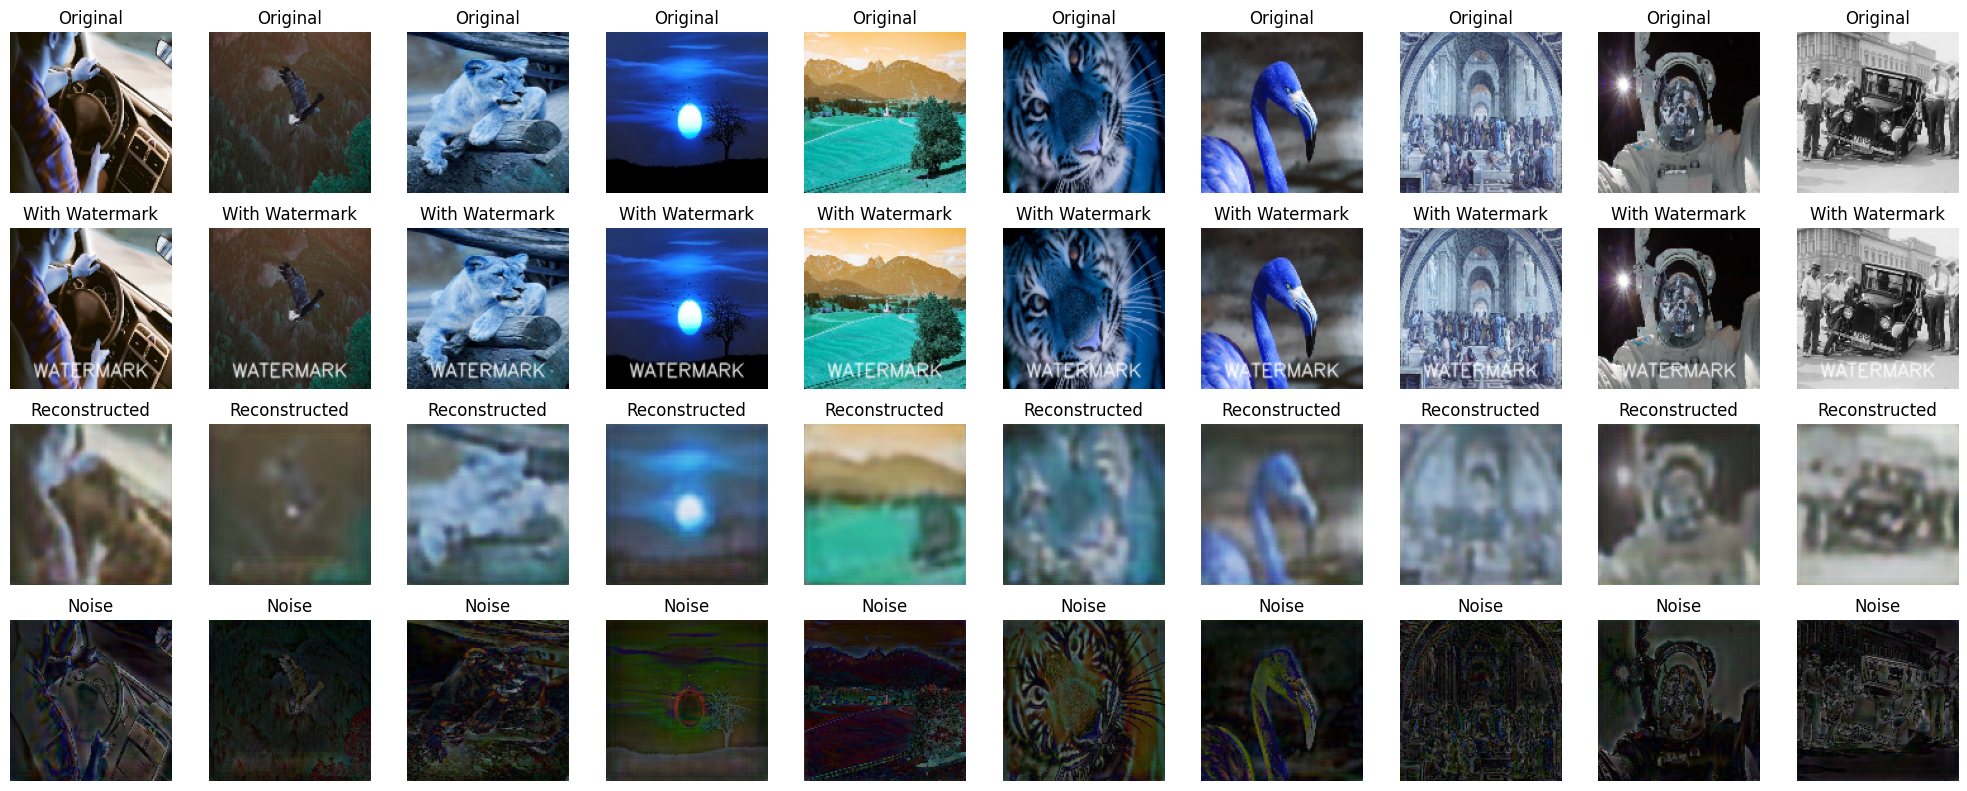

In [31]:
def show_denoising_results(X, Y_true, Y_pred, n=10):
    plt.figure(figsize=(20, 8))
    for i in range(n):
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(Y_true[i])
        ax.set_title("Original")
        plt.axis("off")

        ax = plt.subplot(4, n, i + 1 + n)
        plt.imshow(X[i])
        ax.set_title("With Watermark")
        plt.axis("off")

        ax = plt.subplot(4, n, i + 1 + 2 * n)
        plt.imshow(Y_pred[i])
        ax.set_title("Reconstructed")
        plt.axis("off")

        noise = np.abs(Y_pred[i] - Y_true[i])
        ax = plt.subplot(4, n, i + 1 + 3 * n)
        plt.imshow(noise)
        ax.set_title("Noise")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_denoising_results(X_valid, Y_valid, preds, n=10)

## Calculating PSNR (Peak Signal-to-Noise Ratio)

In [32]:
import math

def psnr(target, ref):
    mse = np.mean((target - ref) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

psnrs = [psnr(Y_valid[i], preds[i]) for i in range(len(preds))]
print(f"📈 Average PSNR: {np.mean(psnrs):.4f}")

📈 Average PSNR: 18.0089


# Conclusion on the work

As part of the completed project, a system for removing watermarks from images based on a convolutional autoencoder was successfully implemented. The model was trained on synthetically created examples, where watermarks in the form of text were added on top of the original images. The model was trained in several stages, taking into account the limitations of Google Colab's RAM.

Average PSNR: `18.0089` is a decent result for a basic autoencoder without additional loss functions and special watermark suppression techniques.